# Background Information

Why k-Medoids instead of k-Means? k-Means is based on within-cluster variance minimization, which is equal to the sum of squared euclidean distances between each point to its cluster centroid. Because it's based on squared Euclidean distances, it's not robust against outliers. You can't use other distance metrics with k-Means because the algorithm may not converge.

What is a medoid? The medoid of a cluster is an existing point in your set with the smallest average distance to all other points. With k-Medoids, you can use any arbitary distance measure, so we use Manhattan distance to be more robust against outliers. However, a drawback of k-Medoids is that it is much more computationally expensive. 

There are multiple algorithms associated with k-Medoids. PAM (Partitioning Around Medoids) was the first algorithm developed, and performs an exhaustive search. Since it's computationally aggressive, other algorithms such as CLARA and CLARANS were introduced. In this notebook, we compare PAM and CLARANS. We ignore CLARA, since CLARANS has been shown to have better performance than CLARA, and we use PAM as our baseline.

## Evaluating Cluster Quality
How do we know if we have "good" clusters? The answers to this question will change depending on your use case, but in general, we often look for low in-cluster variation and high separation of our clusters.

To evaluate our clusters and choose the appropriate number of clusters, we look at the following metrics: 

* **Inter-cluster Distance**: Sum of distances between each cluster centroid/medoid
* **Intra-cluster Distance**: Sum of distances between each item in a cluster and its centroid/medoid. Also known as the "Total Deviation"
* **Maximum Radius**: The largest distance from an item to its cluster centroid/medoid across all of the clusters
* **Average Radius**: Sum of the maximum radiii divided by the number of clusters
* **Silhouette Score**: Measures how close each point in one cluster is to points in the closest neighboring cluster. A value of 0 indicates that a sample is on or very close to the decision boundary between two clusters. A sample close to +1 indicates that it is far away from neighboring clusters. 

The ones we focus on are intra-cluster distance & silhouette score. 


# PAM

## PAM Algorithm

The PAM algorithm consists of two phases: build and swap. In the build phase, we initialize our starting medoids. In the swap phase, for each medoid, we trade out a medoid for the non-medoid point that reduces the total deviation the most. We stop searching when there are no changes to the set of medoids.

### Build
Typically, the initial medoids are chosen randomly. However, if we choose our initial medoids more intelligently, we can reduce the number of iterations in the SWAP phase. Schubert & Rousseeuw outline an algorithm to choose good medoids. The following algorithm is fairly expensive, requiring \\( O(n^2k) \\) time

1. We choose our first medoid to be the point that yields the smallest distance to all others
2. For each following medoid, we choose the point that will reduce the total deviation the most

It may be viable to use the same initialization strategy that is commonly used in kMeans, known as kMeans++, which is \\( O(nk) \\). Instead of equally choosing any point to be a medoid, the probability of selecting a point is proportional to its distance to the closest medoid. The basic idea is that good medoids are more likely to be far away from each other. 

1. Choose one medoid taken uniformly at random from the data set
2. Choose a new medoid, giving each point the probability \\( \frac{D(x)^2}{\Sigma_{x \in \mathcal{X}} D(x)^2} \\), where \\( D(x) \\) is the distance between a point  \\( x \\) and its closest medoid
3. Repeat step 2 until we have k medoids

### Swap

1. For each medoid, we swap the medoid with a non-medoid point if it reduces the total deviation. We replace the medoid with the point that reduces the total deviation the most.
2. If at least one medoid changed, we repeat step 1. We stop the search if we go through an iteration without changing any of the medoids

### References for Algorithms

Schubert, E., & Rousseeuw, P. J. (2018). Faster k-Medoids Clustering: Improving the PAM, CLARA, and CLARANS Algorithms. ArXiv, 1-9.

David Arthur and Sergei Vassilvitskii. 2007. k-means++: the advantages of careful seeding. In Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms (SODA '07). Society for Industrial and Applied Mathematics, Philadelphia, PA, USA, 1027-1035.

In [6]:
# Functions Used for both PAM & CLARANS

import time
from copy import deepcopy
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def build(D, k, init = 'default'):
    m, n = D.shape
    
    if init == 'default': 
        # This is the method outlined in the Oct. 2018 Schubert & Rousseeuw Paper
        # O(n^2k)
        M = [] # M is a list that holds the indices of the medoids

        # The first medoid is the one that has the smallest average distance
        # to all other points
        M.append(np.argmin(np.mean(D, axis=1)))

        # For other medoids, we find the next point that reduces TD the most
        for kappa in range(1, k):
            not_medoids = [i for i in range(n) if i not in M] # indices of points that are not medoids
            TD_best = np.inf 
            C = {}
            for o in not_medoids:
                M_temp = M + [o]
                C = assign_medoids(D, M_temp)
                TD = get_total_deviation(C, M_temp, D)
                if TD < TD_best:
                    TD_best = TD
                    new_medoid = o
            M.append(new_medoid)
        C_best = assign_medoids(D, M)
        build_result = (C_best, M, TD_best)
        
    elif init == 'random':
        # Choose medoids randomly
        M = np.random.choice(range(n), k, replace=False).tolist()
        C = assign_medoids(D, M)
        TD = get_total_deviation(C, M, D)
        build_result = (C, M, TD)
        
    elif init == 'kmeans++':
        M = []
        # The first medoid is chosen randomly
        M.append(np.random.choice(range(n), 1)[0])
        for kappa in range(1,k):
            # The rest are chosen such that a point farther away from 
            # an existing medoid is more likely
            pdf = get_plusplus_pdf(M, D)
            new_medoid = np.random.choice(range(n), 1, p = pdf)[0]
            M.append(new_medoid)
        C = assign_medoids(D, M)
        TD = get_total_deviation(C, M, D)
        build_result = (C, M, TD)
    return build_result

def get_plusplus_pdf(M, D):
    # dists is a n x 1 array, where the value is the distance
    # from x to the closest medoid 
    dist_to_medoids = D[:, M]
    dists = np.amin(dist_to_medoids, axis = 1) 
    d_square_sum = np.sum(dists**2)
    pdf = (dists**2) / d_square_sum
    return pdf

def assign_medoids(D, M):
    k = len(M) # number of clusters
    J = np.argmin(D[:, M], axis=1)
    C = {}
    for kappa in range(k):
        C[kappa] = np.where(J == kappa)[0]
    return C

def get_total_deviation(C, M, D):
    # The total deviation is the sum of the distance between every point and its medoid
    # C is a dictionary with the cluster assignments
    # M is the indices of the medoids
    # D is the distance matrix

    k = len(C)
    TD = 0
    for kappa in range(k):
            TD += np.sum(D[C[kappa], M[kappa]])
    return TD

def evaluate_medoids(C, M, D, silhouette_sample_size=5000, return_intra_cluster = False):
    # Evaluates the cluster quality by determining:
    # The Average Radius
    # The Maximum Radius
    # The intra-cluster score
    # The silhouette score
    # By default, we don't return the intra-cluster score because that will likely already be calculated
    m,n = D.shape
    k = len(C)
    radii = []
    intra_cluster_score = 0
    for kappa in range(k):
        # calculate radii (largest distance from an item to its cluster centroid/medoid)
        radii.append(max(D[C[kappa], M[kappa]]))
        if return_intra_cluster == True:
            # calculate intra-cluster distance (sum of distances between each item to its cluster medoid)
            intra_cluster_score += np.sum(D[C[kappa], M[kappa]])
        
    # calculate inter-cluster distance (sum of distances between each cluster medoid)
    inter_cluster_score = np.sum(D[np.ix_(M, M)]) / 2 # we divide by two because the distance matrix is symmetric
    
    average_radius = np.mean(radii)
    max_radius = np.max(radii)
    silhouette = silhouette_score(D, labels=get_cluster_labels(C, n), metric="precomputed", sample_size=silhouette_sample_size)
    
    metrics = {
        'inter_cluster': inter_cluster_score,
        'average_radius': average_radius,
        'max_radius': max_radius,
        'silhouette': silhouette
    }
    
    if return_intra_cluster == True:
        metrics['intra_cluster'] = intra_cluster_score
    
    return metrics

def get_cluster_labels(C, n):
    cluster_labels = np.zeros(n)
    for i in range(len(C)):
        cluster_labels[C[i]] = i
    return cluster_labels

def cluster_analysis(distances, k_min = 2, k_max = 10, method = 'clarans', build_init = 'default', silhouette_sample_size = 5000):
    # Analyzes clusters using silhouette & elbow method
    m, n = distances.shape
    intra_scores = []
    silhouette_scores = []
    all_metrics = []
    
    for k in range(k_min, k_max + 1):
        if method == 'clarans':
            C, M, metrics = clarans(D, k, init = build_init)
        elif method == 'pam':
            C, M, metrics = pam(D, k, init = build_init)
        all_metrics.append(metrics)
        intra_scores.append(metrics['intra_cluster'])
        silhouette_scores.append(metrics['silhouette'])
    
    # Plot the Results
    plt.clf()

    fig, ax1 = plt.subplots(figsize=(8,5))
    fig.suptitle('Cluster Analysis')

    color = sns.color_palette()[0]
    ax1.set_xlabel('k Clusters')
    ax1.set_ylabel('Intra-Cluster Score', color = color)
    ax1.tick_params(axis='y', labelcolor = color)
    ax1.plot(range(k_min, k_max + 1), intra_scores, color = color)

    ax2 = ax1.twinx()

    color = sns.color_palette()[1]
    ax2.set_ylabel('Silhoutte Score', color = color)
    ax2.tick_params(axis='y', labelcolor = color)
    ax2.plot(range(k_min, k_max + 1), silhouette_scores, color = color)

    display(plt.show())
    
    return all_metrics

def print_cluster_analysis_report(all_metrics, k_min, k_max):
    Ks = range(k_min, k_max + 1)
    for i in range(len(all_metrics)):
        print("For k_clusters =", Ks[i])
        print("The intra-cluster score is:", all_metrics[i]['intra_cluster'])
        print("The inter-cluster score is:", all_metrics[i]['inter_cluster'])
        print("The average radius is:", all_metrics[i]['average_radius'])
        print("The maximum radius is:", all_metrics[i]['max_radius'])
        print("The average silhouette_score is:", all_metrics[i]['silhouette'])
        print("")

In [373]:
def pam(D, k, max_iters = None, init = 'default'):
    m,n = D.shape
    if max_iters == None:
        # if maximum iterations was not set manually
        max_iters = 2*k # Generally, the algorithm goes through < k iterations

    # BUILD
    start = time.time()
    C_best, medoids, TD_best = build(D, k, init = init)
    end = time.time()
    build_time = end - start

    # SWAP
    start = time.time()
    medoid_swapped = True # Initialize to True to start Swap phase
    iters = 0
    while medoid_swapped and iters < max_iters:
        medoid_swapped = False
        for i, m in enumerate(medoids):
            not_medoids = [i for i in range(n) if i not in medoids]
            best_replacement_medoid = m # initialize to the current medoid
            for o in not_medoids:
                temp_medoids = deepcopy(medoids)
                temp_medoids[i] = o
                C = assign_medoids(D, temp_medoids) # Gets cluster assignments for each point according to these temporary medoids
                TD = get_total_deviation(C, temp_medoids, D)
                if TD < TD_best:
                    TD_best = TD
                    best_replacement_medoid = o
                    medoid_swapped = True
                    C_best = C
                medoids[i] = best_replacement_medoid
        iters += 1
    end = time.time()
    swap_time = end - start
    
    # get cluster metrics
    metrics = evaluate_medoids(C_best, medoids, D)
    
    # Add additional metrics
    metrics['intra_cluster'] = TD_best
    metrics['iters'] = iters
    metrics['compute_time'] = {
        'build': build_time,
        'swap': swap_time
    }
    return C_best, medoids, metrics

## kMedoids vs. kMeans

In [3]:
from sklearn import datasets

blobs, blob_clusters = datasets.make_blobs(n_samples = 100, random_state = 15)

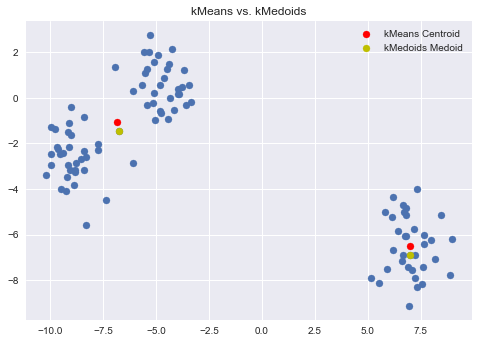

In [378]:
from sklearn.cluster import KMeans

start = time.time()
kmeans = KMeans(n_clusters = 2).fit(blobs)
centroids = kmeans.cluster_centers_
end = time.time()
kmeans_time = end - start

start = time.time()
D = pairwise_distances(blobs, metric='manhattan')
C, M, metrics = pam(D, 2)
end = time.time()
kmedoids_time = end - start

plt.scatter(blobs[:, 0], blobs[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'r', label='kMeans Centroid') # Kmeans
plt.scatter(blobs[M, 0], blobs[M, 1], c='y', label='kMedoids Medoid')
plt.title('kMeans vs. kMedoids')
plt.legend()
plt.show()

In [284]:
print('kMeans Centroids')
print(centroids)

print('kMedoids Medoids')
print(blobs[M])

kMeans Centroids
[[-6.8578025  -1.04702969]
 [ 7.00492677 -6.49321315]]
kMedoids Medoids
[[-6.73764256 -1.47020987]
 [ 6.97582544 -6.91233412]]


In [379]:
# For Small n, kMedoids is Faster

print('kMeans Execution Time', kmeans_time)
print('kMedoids Execution Time', kmedoids_time)
print('kMedoids Time Breakdown', metrics['compute_time'])

kMeans Execution Time 0.015002727508544922
kMedoids Execution Time 0.030024290084838867
kMedoids Time Breakdown {'build': 0.0039937496185302734, 'swap': 0.024000167846679688}


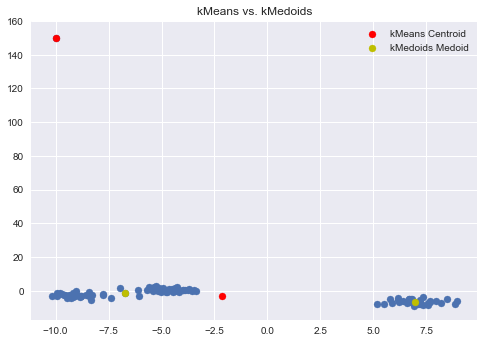

In [380]:
# Add an Outlier

blobs = np.append(blobs, [[-10, 150]], axis=0)

start = time.time()
kmeans = KMeans(n_clusters = 2).fit(blobs)
centroids = kmeans.cluster_centers_
end = time.time()
kmeans_time = end - start

start = time.time()
D = pairwise_distances(blobs, metric='manhattan')
C, M, metrics = pam(D, 2)
end = time.time()
kmedoids_time = end - start

plt.scatter(blobs[:, 0], blobs[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'r', label='kMeans Centroid')
plt.scatter(blobs[M, 0], blobs[M, 1], c='y', label='kMedoids Medoid')
plt.title('kMeans vs. kMedoids')
plt.legend()
plt.show()

In [287]:
# After adding an outlier, the medoids for kMedoids is the same
# but the kMeans centroids change dramatically

print('kMeans Centroids')
print(centroids)

print('kMedoids Medoids')
print(blobs[M])

kMeans Centroids
[[ -2.14447454  -2.89873206]
 [-10.         150.        ]]
kMedoids Medoids
[[-6.73764256 -1.47020987]
 [ 6.97582544 -6.91233412]]


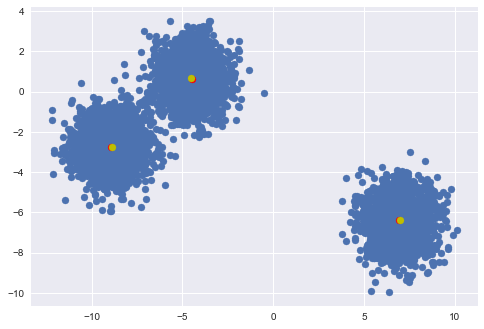

In [288]:
# For Large n, kMedoids is Quite Slow

blobs, blob_clusters = datasets.make_blobs(n_samples = 5000, random_state = 15)

start = time.time()
kmeans = KMeans(n_clusters = 3).fit(blobs)
centroids = kmeans.cluster_centers_
end = time.time()
kmeans_time = end - start

start = time.time()
D = pairwise_distances(blobs, metric='manhattan')
C, M, metrics = pam(D, 3)
end = time.time()
kmedoids_time = end - start

plt.scatter(blobs[:, 0], blobs[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'r') # Kmeans
plt.scatter(blobs[M, 0], blobs[M, 1], c='y')
plt.show()

In [289]:
print('kMeans Execution Time', kmeans_time)
print('kMedoids Execution Time', kmedoids_time)
print('kMedoids Time Breakdown', metrics['compute_time'])

kMeans Execution Time 0.08799886703491211
kMedoids Execution Time 41.47309994697571
kMedoids Time Breakdown {'build': 8.086431980133057, 'swap': 30.740644931793213}


### Summary

For data without outliers, kMeans is a better choice because it runs substantially faster . However, in the presence of outliers, the centroids produced by kMeans are of significantly lesser quality, and in this case we should use kMedoids

## Comparing PAM with Different Initialization Methods

### With Increasing n

In [398]:
ns = [100, 500, 1000, 1500, 2000, 5000]

default_times = []
default_scores = []

plusplus_times = []
plusplus_scores = []

random_times = []
random_scores = []

for n in ns:
    blobs, blob_clusters = datasets.make_blobs(n_samples = n, random_state = 15)
    D = pairwise_distances(blobs, metric='manhattan')
    
    C, M, metrics = pam(D, 3)
    default_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    default_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, 3, init = 'kmeans++')
    plusplus_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    plusplus_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, 3, init = 'random')
    random_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    random_scores.append(metrics['intra_cluster'])

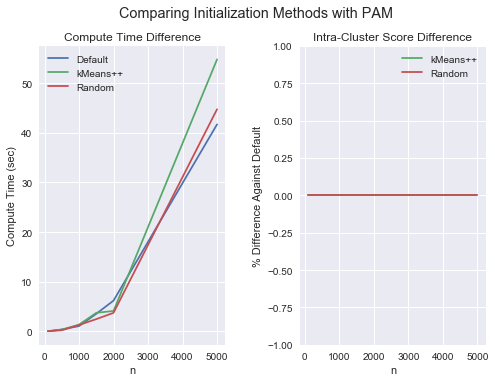

In [399]:
palette = sns.color_palette()

fig, axes = plt.subplots(1, 2)
axes[0].plot(ns, default_times, c = palette[0], label='Default')
axes[0].plot(ns, plusplus_times, c = palette[1], label='kMeans++')
axes[0].plot(ns, random_times, c = palette[2], label = 'Random')
axes[0].legend()
axes[0].set_xlabel('n')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ns, (np.array(plusplus_scores) - np.array(default_scores))*100 / np.array(default_scores), label='kMeans++', c = palette[1])
axes[1].plot(ns, (np.array(random_scores) - np.array(default_scores))*100 / np.array(default_scores), label='Random', c = palette[2])
axes[1].set_ylim(-1, 1)
axes[1].legend()
axes[1].set_xlabel('n')
axes[1].set_ylabel('% Difference Against Default')
axes[1].set_title('Intra-Cluster Score Difference')

fig.suptitle('Comparing Initialization Methods with PAM')
fig.subplots_adjust(wspace = 0.4)
plt.show()

### With Increasing k

In [403]:
ks = [2, 4, 6, 10, 15]

default_times = []
default_scores = []

plusplus_times = []
plusplus_scores = []

random_times = []
random_scores = []

blobs, blob_clusters = datasets.make_blobs(n_samples = 500, random_state = 15)
D = pairwise_distances(blobs, metric='manhattan')

for k in ks:
    
    C, M, metrics = pam(D, k)
    default_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    default_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, k, init = 'kmeans++')
    plusplus_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    plusplus_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, k, init = 'random')
    random_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    random_scores.append(metrics['intra_cluster'])

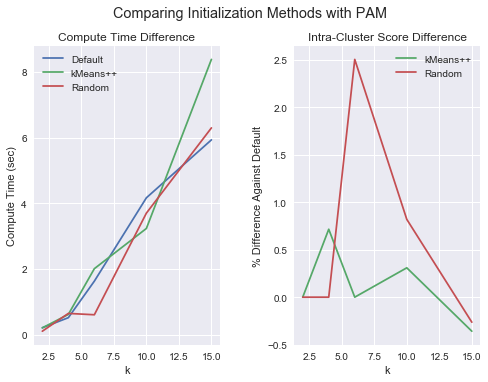

In [404]:
palette = sns.color_palette()

fig, axes = plt.subplots(1, 2)
axes[0].plot(ks, default_times, c = palette[0], label='Default')
axes[0].plot(ks, plusplus_times, c = palette[1], label='kMeans++')
axes[0].plot(ks, random_times, c = palette[2], label = 'Random')
axes[0].legend()
axes[0].set_xlabel('k')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ks, (np.array(plusplus_scores) - np.array(default_scores))*100 / np.array(default_scores), label='kMeans++', c = palette[1])
axes[1].plot(ks, (np.array(random_scores) - np.array(default_scores))*100 / np.array(default_scores), label='Random', c = palette[2])
#axes[1].set_ylim(-1, 1)
axes[1].legend()
axes[1].set_xlabel('k')
axes[1].set_ylabel('% Difference Against Default')
axes[1].set_title('Intra-Cluster Score Difference')

fig.suptitle('Comparing Initialization Methods with PAM')
fig.subplots_adjust(wspace = 0.4)
plt.show()

### Summary

The initialization method has no influence on the resulting intra-cluster score for increasing n, but with increasing k, the default method performs marginally better. The default method is also the fastest in both situations, perhaps because with a better initialization, the "swap" algorithm requires less iterations. In comparison to 'swap', build takes much less time so the compute time is largely driven by 'swap'. 

From these experiments, it appears that we should use PAM with the initialization method outlined by Rousseeuw and Schubert, but the gains in computational time don't seem extremely significant

# CLARANS

CLARANS (Clustering Large Applications Based on Randomized Search) is an algorithm that aims to improve the efficiency of PAM and CLARA. 

At every step in PAM, we exhaustively search for a minimum by looking at all "neighbors" to the current medoid set (where a neighbor is a set of medoids that differs from another by only one element). 

CLARA tries to examine fewer neighbors by drawing a sample of the data at the beginning of the search, whereas CLARANS draws a sample of neighbors in each step of the search. This has the benefit of not confining a search to a local area. 

## Algorithm

1. Initialize `i`, which counts the number of local minima obtained, to 1 and `min_cost` to infinity. Input parameters `num_local` (the number of local minima obtained) and `max_neighbor` (the maximum number of neighbors examined). From the research done by Raymond Ng and Jiawei Han, these parameters can be optimally set to:
$$ num\_local = 2 $$
$$ max\_neighbor = pk(n-k), p \in [0.0125, 0.0150] $$
2. Initialize `current_medoids` either randomly or by our previous method outlined by Rousseeuw & Schubert. 
3. Set `j` to 1. 
4. Consider a random neighbor `neighbor_medoids` of `current_medoids` and calculate the total deviation differential between the two neighbors
5. If `neighbor_medoids` has a lower total deviation, set `current_medoids` to `neighbor_medoids` and go to step 3. 
6. Otherwise increment `j` by 1. If $ j <= max\_neighbor $, go to step 4
7. Otherwise when $ j > max\_neighbor $, compare the total deviation of `current_medoids` with `min_cost`. If $ current\_medoids < min\_cost $, update `min_cost` and set `best_medoids` to `current_medoids`. 
8. Increment `i` by 1. If $ i > num\_local $, return `best_medoids` and halt. Otherwise, go to step 2


## References
Ng, Raymond & Han, Jiawei. (2002). CLARANS: A method for clustering objects for spatial data mining. Knowledge and Data Engineering, IEEE Transactions on. 14. 1003- 1016. 10.1109/TKDE.2002.1033770. 

In [11]:
def clarans(D, k, num_local = 2, max_neighbor = None, init = 'default'):
    m, n = D.shape
    if max_neighbor == None:
        max_neighbor = 0.0150 * k * (n - k)
    elif max_neighbor > k * (n - k):
        max_neighbor = k * (n - k)
    start = time.time()
    i = 1 # keeping track of local minima found
    min_cost = np.inf
    if init == 'default':
        # We can build the initial medoids outside of the while loop since it's deterministic
        init_C, init_medoids, init_TD = build(D, k)
    
    while i <= num_local:
        # Initializing First Set of Medoids
        if init == 'default':
            current_C, current_medoids, current_TD = init_C, init_medoids, init_TD
        else:
            current_C, current_medoids, current_TD = build(D, k, init=init)
        j = 1 # keeping track of how many neighbors we've searched
        
        while j <= max_neighbor:
            neighbor_medoids = generate_neighbor(current_medoids, n)
            neighbor_C = assign_medoids(D, neighbor_medoids)
            neighbor_TD = get_total_deviation(neighbor_C, neighbor_medoids, D)

            if neighbor_TD < current_TD:
                current_medoids = neighbor_medoids
                current_C = neighbor_C
                current_TD = neighbor_TD
                j = 1
            else:
                j += 1
        if current_TD < min_cost:
            min_cost = current_TD
            best_medoids = current_medoids
            best_C = current_C
        i += 1
    end = time.time()
    # get cluster metrics
    metrics = evaluate_medoids(best_C, best_medoids, D)
    metrics['intra_cluster'] = min_cost
    metrics['compute_time'] = end - start
    
    return best_C, best_medoids, metrics
    
def generate_neighbor(medoids, n):
    neighbor = deepcopy(medoids)
    # generate a random medoid in the set to be replaced
    replaced_index = np.random.choice(len(medoids), 1)[0]
    # choose a random non-medoid object to insert
    non_medoids = [nabla for nabla in range(n) if nabla not in medoids]
    new_medoid = np.random.choice(non_medoids, 1)[0]
    neighbor[replaced_index] = new_medoid
    return neighbor

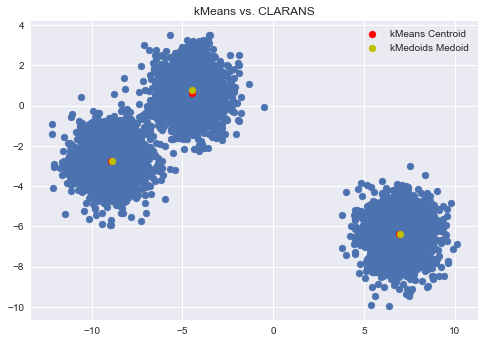

In [409]:
blobs, blob_clusters = datasets.make_blobs(n_samples = 5000, random_state = 15)
start = time.time()
kmeans = KMeans(n_clusters = 3).fit(blobs)
centroids = kmeans.cluster_centers_
end = time.time()
kmeans_time = end - start

D = pairwise_distances(blobs, metric='manhattan')
C, M, metrics = clarans(D, 3)

plt.scatter(blobs[:, 0], blobs[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'r', label='kMeans Centroid') # Kmeans
plt.scatter(blobs[M, 0], blobs[M, 1], c='y', label='kMedoids Medoid')
plt.title('kMeans vs. CLARANS')
plt.legend()
plt.show()

In [410]:
print('kMeans Time:', kmeans_time)
print('CLARANS Time:', metrics['compute_time'])

kMeans Time: 0.061994075775146484
CLARANS Time: 11.859624862670898


## Comparing CLARANS with Different Initializations

Comparing Rousseeuw & Schubert's method, a random initialization, and kmeans++

### With increasing n

In [ ]:
ns = [100, 250, 500, 1000, 2500, 5000, 7500, 10000]

default_times = []
default_scores = []

plusplus_times = []
plusplus_scores = []

random_times = []
random_scores = []

for n in ns:
    blobs, blob_clusters = datasets.make_blobs(n_samples = n, random_state = 15)
    D = pairwise_distances(blobs, metric='manhattan')
    
    C, M, metrics = clarans(D, 3)
    default_times.append(metrics['compute_time'])
    default_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = clarans(D, 3, init = 'kmeans++')
    plusplus_times.append(metrics['compute_time'])
    plusplus_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = clarans(D, 3, init = 'random')
    random_times.append(metrics['compute_time'])
    random_scores.append(metrics['intra_cluster'])

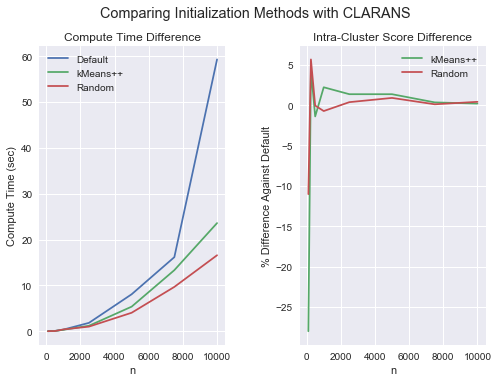

In [371]:
palette = sns.color_palette()

fig, axes = plt.subplots(1, 2)
axes[0].plot(ns, default_times, c = palette[0], label='Default')
axes[0].plot(ns, plusplus_times, c = palette[1], label='kMeans++')
axes[0].plot(ns, random_times, c = palette[2], label = 'Random')
axes[0].legend()
axes[0].set_xlabel('n')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ns, (np.array(plusplus_scores) - np.array(default_scores))*100 / np.array(default_scores), label='kMeans++', c = palette[1])
axes[1].plot(ns, (np.array(random_scores) - np.array(default_scores))*100 / np.array(default_scores), label='Random', c = palette[2])
axes[1].legend()
axes[1].set_xlabel('n')
axes[1].set_ylabel('% Difference Against Default')
axes[1].set_title('Intra-Cluster Score Difference')

fig.suptitle('Comparing Initialization Methods with CLARANS')
fig.subplots_adjust(wspace = 0.4)
plt.show()

### With Increasing k

In [413]:
ks = [2, 4, 6, 10, 15]

default_times = []
default_scores = []

plusplus_times = []
plusplus_scores = []

random_times = []
random_scores = []

blobs, blob_clusters = datasets.make_blobs(n_samples = 5000, random_state = 15)
D = pairwise_distances(blobs, metric='manhattan')

for k in ks:
    
    C, M, metrics = clarans(D, k)
    default_times.append(metrics['compute_time'])
    default_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = clarans(D, k, init = 'kmeans++')
    plusplus_times.append(metrics['compute_time'])
    plusplus_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = clarans(D, k, init = 'random')
    random_times.append(metrics['compute_time'])
    random_scores.append(metrics['intra_cluster'])

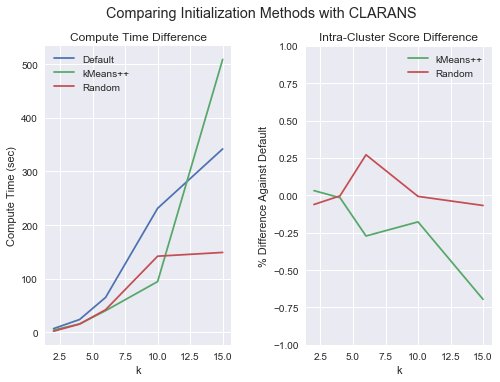

In [415]:
palette = sns.color_palette()

fig, axes = plt.subplots(1, 2)
axes[0].plot(ks, default_times, c = palette[0], label='Default')
axes[0].plot(ks, plusplus_times, c = palette[1], label='kMeans++')
axes[0].plot(ks, random_times, c = palette[2], label = 'Random')
axes[0].legend()
axes[0].set_xlabel('k')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ks, (np.array(plusplus_scores) - np.array(default_scores))*100 / np.array(default_scores), label='kMeans++', c = palette[1])
axes[1].plot(ks, (np.array(random_scores) - np.array(default_scores))*100 / np.array(default_scores), label='Random', c = palette[2])
axes[1].set_ylim(-1, 1)
axes[1].legend()
axes[1].set_xlabel('k')
axes[1].set_ylabel('% Difference Against Default')
axes[1].set_title('Intra-Cluster Score Difference')

fig.suptitle('Comparing Initialization Methods with CLARANS')
fig.subplots_adjust(wspace = 0.4)
plt.show()

### Summary

With CLARANS, the build time becomes significant because the rest of the algorithm is relatively fast. With increasing n, we see that with the computationally intensive build method, the computation time increases at a much faster rate than using kmeans++ and a random initialization. At very small n, CLARANs with the default method performs more poorly than kmeans++ and random. However as n increases, the three initialization methods converge. 

With increasing k, kmeans++ is actually the slowest, and it provided marginally better results at large k. With the random initialization, the algorithm was significantly faster than the rest. Since there isn't a noticeable decrease in cluster quality with a random initialization, to optimize speed, we should use the random method.

## CLARANS vs PAM 

### With increasing n

In [416]:
ns = [100, 250, 500, 1000, 5000, 10000]

pam_times = []
pam_scores = []
clarans_times = []
clarans_scores = []

for n in ns:
    blobs, blob_clusters = datasets.make_blobs(n_samples = n, random_state = 15)
    D = pairwise_distances(blobs, metric='manhattan')
    
    C, M, metrics = clarans(D, 3, init = 'random')
    clarans_times.append(metrics['compute_time'])
    clarans_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, 3)
    pam_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    pam_scores.append(metrics['intra_cluster'])

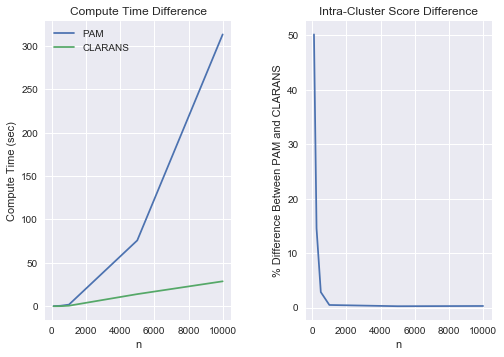

In [417]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(ns, pam_times, label='PAM')
axes[0].plot(ns, clarans_times, label='CLARANS')
axes[0].legend()
axes[0].set_xlabel('n')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ns, (np.array(clarans_scores) - np.array(pam_scores)) / np.array(pam_scores)*100)
axes[1].set_xlabel('n')
axes[1].set_ylabel('% Difference Between PAM and CLARANS')
axes[1].set_title('Intra-Cluster Score Difference')

fig.subplots_adjust(wspace = 0.4)
plt.show()

### With increasing k

In [431]:
ks = [2, 4, 6, 8, 10, 12]

pam_times = []
clarans_times = []
pam_scores = []
clarans_scores = []

blobs, blob_clusters = datasets.make_blobs(n_samples = 1000, random_state = 15)
D = pairwise_distances(blobs, metric='manhattan')

for k in ks:
    C, M, metrics = clarans(D, k)
    clarans_times.append(metrics['compute_time'])
    clarans_scores.append(metrics['intra_cluster'])
    
    C, M, metrics = pam(D, k)
    pam_times.append(metrics['compute_time']['build'] + metrics['compute_time']['swap'])
    pam_scores.append(metrics['intra_cluster'])

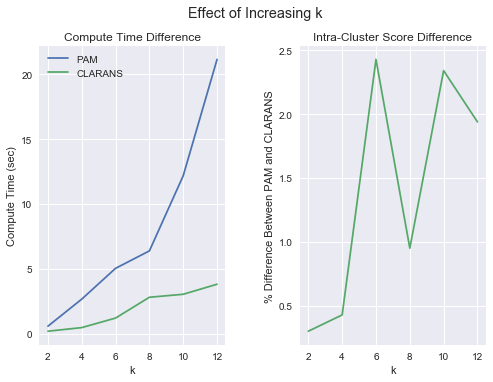

In [432]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(ks, pam_times, label='PAM')
axes[0].plot(ks, clarans_times, label='CLARANS')
axes[0].legend()
axes[0].set_xlabel('k')
axes[0].set_ylabel('Compute Time (sec)')
axes[0].set_title('Compute Time Difference')

axes[1].plot(ks, (np.array(clarans_scores) - np.array(pam_scores)) / np.array(pam_scores)*100, c = palette[1])
axes[1].set_xlabel('k')
axes[1].set_ylabel('% Difference Between PAM and CLARANS')
axes[1].set_title('Intra-Cluster Score Difference')

fig.suptitle('Effect of Increasing k')
fig.subplots_adjust(wspace = 0.4)
plt.show()

### Summary

With small n (n < 1000), CLARANS is much worse at finding quality clusters, which is expected. At $ n >= 1000 $, the difference between PAM and CLARANS in terms of intra-cluster score are minimal. But we see that the computation time for PAM grows exponentially with increasing n, and for CLARANS it looks linear. At n = 10000, we see that the computation time for PAM is approximately 7.5x that of CLARANS.

We also see that with increasing k and fixed n, the computation time for PAM increases at a much higher rate than CLARANS. The intra-cluster difference also doesn't have a significant difference, with CLARANS performing 0-2.5% worse. 

It's obvious from our results that with n > 1000, CLARANS sacrifices little in terms of clustering quality and provides tremendous gains in computation speed

# Choosing the Right Number of Clusters

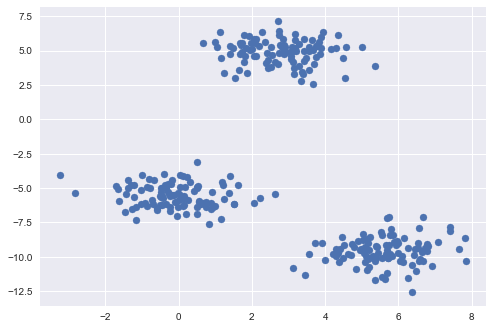

In [76]:
sns.set()
blobs, blob_clusters = datasets.make_blobs(n_samples = 300, random_state = 10)
plt.scatter(blobs[:, 0], blobs[:, 1])
plt.show()

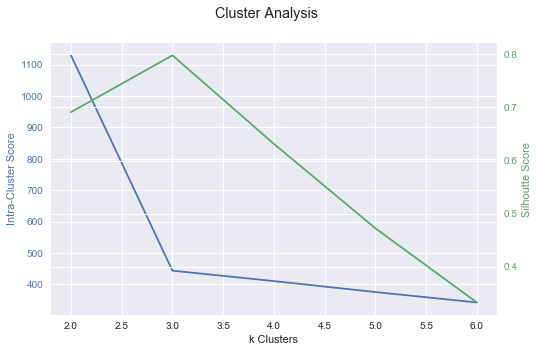

None

In [70]:
D = pairwise_distances(blobs, metric='manhattan')
metrics = cluster_analysis(D, k_min = 2, k_max = 6, build_init = 'random')

In [71]:
print_cluster_analysis_report(metrics, 2, 6)

For k_clusters = 2
The intra-cluster score is: 1129.4034506362966
The inter-cluster score is: 13.995410726459246
The average radius is: 7.103561867945167
The maximum radius is: 10.505180727792855
The average silhouette_score is: 0.691013558008872

For k_clusters = 3
The intra-cluster score is: 444.0486056057432
The inter-cluster score is: 40.66025894177743
The average radius is: 4.130672241176179
The maximum radius is: 4.594913027467151
The average silhouette_score is: 0.7978419062821096

For k_clusters = 4
The intra-cluster score is: 410.85798791889476
The inter-cluster score is: 64.80713435384615
The average radius is: 3.5640213069871596
The maximum radius is: 4.095160687963904
The average silhouette_score is: 0.631297385148814

For k_clusters = 5
The intra-cluster score is: 375.9532954038211
The inter-cluster score is: 110.134782722012
The average radius is: 3.2634649307367196
The maximum radius is: 4.095160687963904
The average silhouette_score is: 0.47253243842659703

For k_cluste

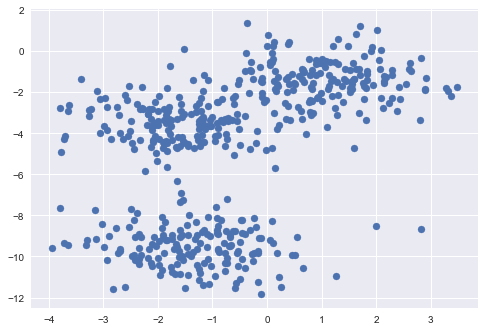

In [112]:
blobs, blob_clusters = datasets.make_blobs(n_samples = 500, random_state = 2)
plt.scatter(blobs[:, 0], blobs[:, 1])
plt.show()

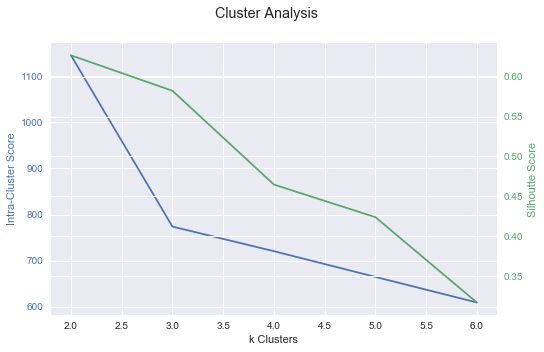

None

In [113]:
D = pairwise_distances(blobs, metric='manhattan')
metrics = cluster_analysis(D, k_min = 2, k_max = 6, build_init = 'random')

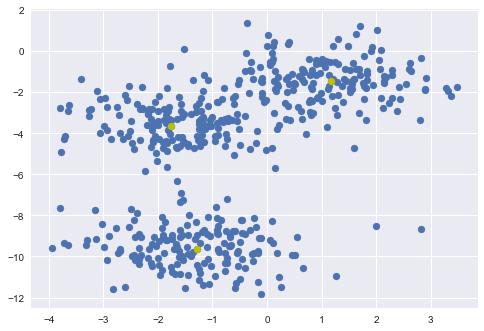

In [120]:
C, M, metrics = pam(D, 3)
plt.scatter(blobs[:, 0], blobs[:, 1])
plt.scatter(blobs[M, 0], blobs[M, 1], c='y')
plt.show()

# Cluster Stability

How stable is this cluster assignment? We'll run the clustering with this k multiple times with random samplings of the population and measure the similarity of the resulting cluster sets. The similarity score ranges from 0 to 1. 1 means that on every subsample run, we received the exact same cluster sets as the original clustering. 

Pseudo Code:
* Re-sample new data sets from the original population and apply the clustering method to them
* For every given cluster in the original clustering, find the most similar cluster in the new clustering and record the similarity score as the number of intersecting items
* Obtain the average similarity score for every cluster in every subsample run

Some people choose the number of clusters, k, as the value that maximizes cluster stability

Some may also argue that this isn't a particularly insightful measure, as it depends on choosing a good proportion to take for the random sample. If the proportion is too high, you haven't changed the subsample enough to be meaningful. If you the proportion is too low, the resulting sample does not resemble your original population well enough. 

In [139]:
def cluster_stability_analysis(D, k, original_C, init = 'default', sample_frac = 0.80, n_subsamples = 10):
    sample_size = round(sample_frac * D.shape[0])
    best_scores = [] # stores the best scores, will be an array k * n_subsamples long
    for n in range(n_subsamples):
        random_rows = np.random.choice(D.shape[0], sample_size, replace=False)
        C, M_temp, metrics = clarans(D[np.ix_(random_rows, random_rows)], k, init = init) # runs clarans on a subsample
        # M_temp is mapped to the sampled rows, lets get these same medoids in the context of the entire population
        M = random_rows[M_temp]
        # Let's cluster the entire set based off of these medoids
        C = assign_medoids(D, M)
        for original_cluster, original_members in original_C.items():
            # for each original cluster, we find the "new cluster" that is most similar and record the score
            best_score = 0
            for new_cluster, new_members in C.items():
                intersection = set(original_members).intersection(set(new_members))
                score = len(intersection)
                if score > best_score:
                    best_score = score
            best_scores.append(best_score)
    stability_score = np.sum(np.array(best_scores)) / (D.shape[0] * n_subsamples)
    return stability_score

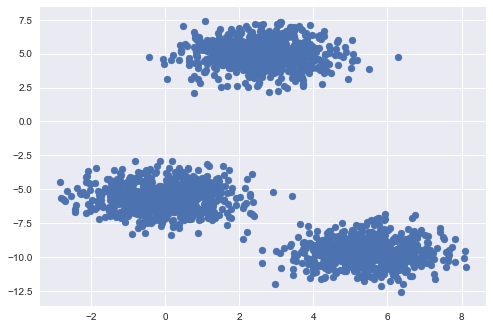

In [138]:
# Let's check the cluster stability for this previous data set
sns.set()
blobs, blob_clusters = datasets.make_blobs(n_samples = 2000, random_state = 10)
plt.scatter(blobs[:, 0], blobs[:, 1])
plt.show()

In [144]:
D = pairwise_distances(blobs, metric = 'manhattan')
C, M, metrics = clarans(D, 3, init = 'random')
cluster_stability_analysis(D, 3, C, init='random', sample_frac = 0.7, n_subsamples = 5)

0.9998

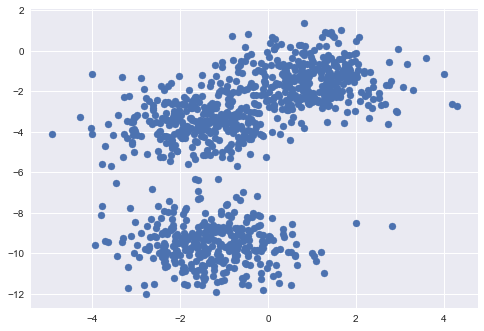

In [147]:
# How about for this data set
blobs, blob_clusters = datasets.make_blobs(n_samples = 1000, random_state = 2)
plt.scatter(blobs[:, 0], blobs[:, 1])
plt.show()

In [148]:
D = pairwise_distances(blobs, metric = 'manhattan')
C, M, metrics = clarans(D, 3, init = 'random')
cluster_stability_analysis(D, 3, C, init='random', sample_frac = 0.7, n_subsamples = 5)

0.986

In [149]:
# What if we choose a poorer choice for k?

D = pairwise_distances(blobs, metric = 'manhattan')
C, M, metrics = clarans(D, 5, init = 'random')
cluster_stability_analysis(D, 5, C, init='random', sample_frac = 0.7, n_subsamples = 5)

0.7288